In [53]:
import torch
import torch.nn as nn
import numpy as np

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device {device}")

Using device mps


### Project 1: Predicting Fuel Efficiency of a Car

In [6]:
import pandas as pd 

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"

column_names = ["MPG", "Cylinders", "Displacement", "Horsepower",
                "Weight", "Acceleration", "Model Year", "Origin"]

mpg_df = pd.read_csv(url, names=column_names, na_values="?",
                    comment="\t", sep=" ", skipinitialspace=True)

In [7]:
mpg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


In [10]:
# since the NA rows aren't too much in quantity, drop them
mpg_df.dropna(inplace=True)
mpg_df.reset_index(drop=True, inplace=True)
mpg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           392 non-null    float64
 1   Cylinders     392 non-null    int64  
 2   Displacement  392 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        392 non-null    float64
 5   Acceleration  392 non-null    float64
 6   Model Year    392 non-null    int64  
 7   Origin        392 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 24.6 KB


### Data Normalization

In [12]:
import sklearn
from sklearn.model_selection import train_test_split

# train test split
df_train, df_test = train_test_split(mpg_df, train_size=0.8, random_state=42)
train_stats = df_train.describe().transpose()
print(train_stats)

              count         mean         std     min     25%     50%     75%  \
MPG           313.0    23.599361    7.956255     9.0    17.0    23.0    30.0   
Cylinders     313.0     5.482428    1.700446     3.0     4.0     4.0     8.0   
Displacement  313.0   195.517572  103.766567    70.0   105.0   151.0   302.0   
Horsepower    313.0   104.594249   38.283669    46.0    76.0    95.0   129.0   
Weight        313.0  2986.124601  841.133957  1613.0  2234.0  2855.0  3645.0   
Acceleration  313.0    15.544089    2.817864     8.0    13.5    15.5    17.3   
Model Year    313.0    76.207668    3.630136    70.0    73.0    76.0    79.0   
Origin        313.0     1.555911    0.807163     1.0     1.0     1.0     2.0   

                 max  
MPG             46.6  
Cylinders        8.0  
Displacement   455.0  
Horsepower     230.0  
Weight        5140.0  
Acceleration    24.8  
Model Year      82.0  
Origin           3.0  


In [13]:
numerical_columns = ["Cylinders", "Displacement", "Horsepower",
                     "Weight", "Acceleration"]
df_train_norm, df_test_norm = df_train.copy(), df_test.copy()

# do some normalization on the numerical/continuous values
for col_name in numerical_columns:
    mean = train_stats.loc[col_name, "mean"]
    std = train_stats.loc[col_name, "std"]
    df_train_norm.loc[:, col_name] = (df_train_norm.loc[:, col_name] - mean) / std
    df_test_norm.loc[:, col_name] = (df_test_norm.loc[:, col_name] - mean) / std

df_train_norm.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
71,15.0,1.480536,1.045447,1.186034,1.076969,-1.080283,72,1
106,18.0,0.304374,0.351582,-0.120005,-0.234356,-0.193086,73,1
270,23.8,-0.871788,-0.429017,-0.511817,-0.155890,0.729599,78,1
348,29.9,-0.871788,-0.939778,-1.034233,-0.720604,1.829723,81,1
102,11.0,1.480536,1.970600,1.186034,2.390672,-0.547965,73,1


### Bucketing

In [15]:
boundaries = torch.tensor([73, 76, 79])
v = torch.tensor(df_train_norm["Model Year"].values)
df_train_norm["Model Year Bucketed"] = torch.bucketize(v, boundaries, right=True)

v = torch.tensor(df_test_norm["Model Year"].values)
df_test_norm["Model Year Bucketed"] = torch.bucketize(v, boundaries, right=True)

numerical_columns.append("Model Year Bucketed")

### Processing Categorical (Non-ordered) Data

In [18]:
# can use either an embedding or one-hot
# for large number of categorical features, an embedding is more efficient
from torch.nn.functional import one_hot
total_origin = len(set(df_train_norm["Origin"]))
origin_encoded = one_hot(torch.from_numpy(df_train_norm["Origin"].values) % total_origin)
x_train_numeric = torch.tensor(df_train_norm[numerical_columns].values)
x_train = torch.cat([x_train_numeric, origin_encoded], dim=1).float()

origin_encoded = one_hot(torch.from_numpy(df_test_norm["Origin"].values) % total_origin)
x_test_numeric = torch.tensor(df_test_norm[numerical_columns].values)
x_test = torch.cat([x_test_numeric, origin_encoded], dim=1).float()

In [19]:
# set the labels
y_train = torch.tensor(df_train_norm["MPG"].values).float()
y_test = torch.tensor(df_test_norm["MPG"].values).float()

### Training a DNN Regression Model

In [21]:
from torch.utils.data import TensorDataset, DataLoader

train_ds = TensorDataset(x_train, y_train)
batch_size = 8
torch.manual_seed(42)
train_loader = DataLoader(train_ds, batch_size, shuffle=True)

In [28]:
class RegressionModel(nn.Module):
    def __init__(self, input_size: int, output_size: int, hidden_sizes=[8, 4]):
        super().__init__()
        layer_sizes = [input_size] + hidden_sizes
        layers = []
        for i in range(1, len(layer_sizes)):
            layers.append(nn.Linear(layer_sizes[i-1], layer_sizes[i]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(layer_sizes[-1], output_size))
        
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

In [55]:
reg_model = RegressionModel(x_train.shape[1], 1)
print(reg_model)

RegressionModel(
  (layers): Sequential(
    (0): Linear(in_features=9, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
  )
)


In [56]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(reg_model.parameters(), lr=0.001)

In [57]:
# train the model
torch.manual_seed(1)
num_epochs = 200
log_epochs = 20
train_loss = 0

reg_model.to(device)
reg_model.train()
losses = 0.0
loss_history = []
num_examples = 0
for e in range(num_epochs):
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        predictions = reg_model(features)[:,0]
        loss = loss_fn(predictions, labels)
        # logging 
        num_examples += features.shape[0]
        losses += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_history.append(losses/num_examples)

    if e % log_epochs == 0:
        print(f"Epoch {e}/{num_epochs}: MSE Loss = {(losses/num_examples):.4f}")

Epoch 0/200: MSE Loss = 43.7729
Epoch 20/200: MSE Loss = 3.3474
Epoch 40/200: MSE Loss = 2.2920
Epoch 60/200: MSE Loss = 1.9230
Epoch 80/200: MSE Loss = 1.7296
Epoch 100/200: MSE Loss = 1.6010
Epoch 120/200: MSE Loss = 1.5115
Epoch 140/200: MSE Loss = 1.4530
Epoch 160/200: MSE Loss = 1.4023
Epoch 180/200: MSE Loss = 1.3656


### Evaluation


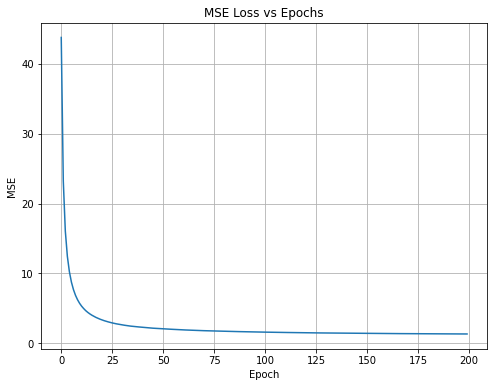

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt

idx = [i for i in range(len(loss_history))]
plt.figure(figsize=(8,6))
plt.plot(idx, loss_history)
plt.title("MSE Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.grid()
plt.show()

In [72]:
# check MSE and MAE on test set
reg_model.eval()
reg_model.cpu()
with torch.no_grad():
    preds = reg_model(x_test.float()).squeeze()
    loss = loss_fn(preds, y_test)
    print(f"MSE Test Loss = {loss.item():.4f}")
    print(f"MAE Test Loss = {nn.L1Loss()(preds, y_test).item():.4f}")

MSE Test Loss = 7.5569
MAE Test Loss = 2.0705
